In [1]:
# Install dependencies for Gemini and Hugging Face quantization
!pip install -q google-generativeai nest_asyncio
!pip install -q transformers accelerate bitsandbytes
!pip install -q sentence-transformers evaluate rouge_score
!pip install -q evaluate # Ensure evaluate is installed
!pip install -U bitsandbytes

In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import gc
import asyncio
import nest_asyncio
import google.generativeai as genai
from google.api_core import exceptions
from sentence_transformers import SentenceTransformer, util
import evaluate
import numpy as np
import json
import time
import os
import google.auth
import gspread
import gspread_dataframe
from google.auth import default as get_default_credentials

In [3]:
import google.auth
from google.colab import auth
# 1. Authenticate the user
auth.authenticate_user()

# 2. Get the credentials
creds, _ = google.auth.default()

# 3. Authorize gspread
gs = gspread.authorize(creds)

# 4. Open the sheet
spreadsheet_url = "https://docs.google.com/spreadsheets/d/13AsHGT68HfClFbPXLJNjrXSTtq7UggnqkXKgV9YC78w"
wks = gs.open_by_url(spreadsheet_url).worksheet('Sheet1')

# 5. Correct function name: get_as_dataframe
df_gsheet = gspread_dataframe.get_as_dataframe(wks)

# 6. Select columns and clean up empty rows/columns (common with gspread_dataframe)
df_test_cases = df_gsheet[['Question', 'Doctor_answer']].head(5)

print("Successfully loaded data:")
print(df_test_cases)

Successfully loaded data:
                                            Question  \
0  A one week old baby with small white pimples m...   
1  Hi my wife was 40 weeks 5 days pregnant and th...   
2  Hi Doc Ive been coughing since d past few days...   
3                        Is face mask compulsory now   
4  Where can one find a covid 19 test center in L...   

                                       Doctor_answer  
0  A newborn's skin is prone to all sorts of rash...  
1  Hi congratulations on the new baby Pending the...  
2  Hello\n\nGood evening I do not think its COVID...  
3  Hi Temitope and thanks for using #######\n\nI ...  
4  Currently there are six testing centers across...  


In [13]:
# Apply Async Patch (if not already applied)
nest_asyncio.apply()

# Setup Google Gemini (The Judge)
# Ensure your GOOGLE_API_KEY is set in the environment or directly here
# For Colab, it's recommended to store it as a Colab secret
os.environ["GOOGLE_API_KEY"] = "APIKEY"
genai.configure(api_key=os.environ.get("GOOGLE_API_KEY"), transport="rest")

# Re-defining model_ids and bnb_config
model_ids = [
    "Qwen/Qwen2.5-1.5B-Instruct",
    "microsoft/phi-3.5-mini-instruct",
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "stabilityai/stablelm-zephyr-3b"

]
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

# Helper function to clear GPU memory
def cleanup():
    # Using 'global' ensures we are pointing to the models defined outside
    global model, tokenizer

    if 'model' in globals(): del model
    if 'tokenizer' in globals(): del tokenizer

    import gc # Import here specifically to be safe
    gc.collect()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    print("GPU Memory Cleared.")

In [18]:
from IPython.display import Javascript

# This Javascript command directly removes the 'widgets' metadata entry from the current notebook
display(Javascript('IPython.notebook.metadata.widgets = {};'))

print("Notebook metadata 'widgets' entry cleared. Please save your notebook (File -> Save) and then try saving to GitHub again.")

<IPython.core.display.Javascript object>

Notebook metadata 'widgets' entry cleared. Please save your notebook (File -> Save) and then try saving to GitHub again.


In [5]:
# --- Data Structure ---
class LLMTestCase:
    def __init__(self, input_query: str, reference_answer: str):
        self.input = input_query
        self.reference = reference_answer  # The "Gold Standard"
        self.actual_output = None
        self.scores = {} # Dictionary to store multiple metrics
        self.reasoning = None

# --- The "Evaluatee" (Lightweight Model Wrapper) ---
class MedicalLLMClient:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def generate_answer(self, test_case: LLMTestCase):
        messages = [
            {"role": "system", "content": "You are a specialized medical assistant. Answer the user's question. Be highly concise and professional."},
            {"role": "user", "content": test_case.input}
        ]

        text = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        inputs = self.tokenizer([text], return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=150,
                temperature=0.3 # Keep it factual
            )

        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        if "assistant" in response:
            return response.split("assistant")[-1].strip()
        return response.split("\n")[-1].strip()

# --- The "Judge" (Gemini Wrapper) ---
class GeminiRelevancyMetric:
    def __init__(self):
        self.judge_model = genai.GenerativeModel(
            model_name='gemini-2.5-flash'
        )

    def evaluate_with_retry(self, prompt, retries=3, delay=2):
        for i in range(retries):
            try:
                response = self.judge_model.generate_content(
                    prompt,
                    generation_config={"response_mime_type": "application/json"}
                )
                return response.text
            except (exceptions.InternalServerError, exceptions.ServiceUnavailable, Exception) as e:
                if i == retries - 1: raise e
                print(f"   Connection glitch, retrying in {delay}s... ({str(e)[:50]})")
                time.sleep(delay)
                delay *= 2

    async def evaluate(self, test_case: LLMTestCase):
        evaluation_prompt = f"""
        You are an expert medical evaluator.
        rate the answer given and give score with the highest being 1.

        Question: {test_case.input}
        Actual Output: {test_case.actual_output}

        Return JSON: {{\"score\": float, \"reason\": string}}
        """

        try:
            loop = asyncio.get_event_loop()
            raw_text = await loop.run_in_executor(None, self.evaluate_with_retry, evaluation_prompt)

            clean_json = raw_text.replace('```json', '').replace('```', '').strip()
            result = json.loads(clean_json)

            test_case.score = result.get("score", 0)
            test_case.reasoning = result.get("reason", "No reason provided")
        except Exception as e:
            test_case.score = 0
            test_case.reasoning = f"Evaluation Failed: {str(e)}"

        return test_case.score

# --- Advanced Evaluator ---
class AdvancedEvaluator:
    def __init__(self):
        self.sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.rouge = evaluate.load('rouge')

    def calculate_metrics(self, test_case: LLMTestCase):
        ref = test_case.reference
        hyp = test_case.actual_output

        emb1 = self.sbert_model.encode(ref, convert_to_tensor=True)
        emb2 = self.sbert_model.encode(hyp, convert_to_tensor=True)
        sbert_score = util.cos_sim(emb1, emb2).item()

        rouge_results = self.rouge.compute(
            predictions=[hyp],
            references=[ref],
            use_aggregator=False
        )

        test_case.scores = {
            "SBERT_Similarity": round(sbert_score, 4),
            "F1_Score": round(rouge_results['rougeL'][0], 4),
            "Recall": round(rouge_results['rouge1'][0], 4),
            "Precision": round(rouge_results['rouge2'][0], 4)
        }

# 1. Define Medical Test Cases from Google Sheet
def create_medical_test_cases(df):
    medical_test_cases = []
    for _, row in df.iterrows():
        medical_test_cases.append(
            LLMTestCase(
                input_query=row['Question'],
                reference_answer=row['Doctor_answer']
            )
        )
    return medical_test_cases

In [14]:
# --- Generate and Evaluate ---
async def run_full_pipeline(model, tokenizer, test_cases):
    print(f"--- Processing {len(test_cases)} Medical Queries ---")

    med_client = MedicalLLMClient(model, tokenizer)
    gemini_judge = GeminiRelevancyMetric()
    adv_evaluator = AdvancedEvaluator()

    for i, case in enumerate(test_cases):
        print(f"\n[{i+1}/{len(test_cases)}] Question: {case.input}")
        case.actual_output = med_client.generate_answer(case)
        print(f"   Response: {case.actual_output[:100]}...")

        print("   Calculating SBERT & Overlap scores...")
        adv_evaluator.calculate_metrics(case)

        print("   Requesting Gemini Judge Evaluation...")
        await gemini_judge.evaluate(case)
        print(f"   Score: {case.score} | Reason: {case.reasoning[:60]}...")

        if i < len(test_cases) - 1:
            print("   Sleeping 6s to avoid API Quota (429) errors...")
            await asyncio.sleep(6)

    print("\nAll evaluations complete for this model.")

    current_model_results = []
    for c in test_cases:
        res = {
            "Question": c.input,
            "Judge Score": c.score,
            "SBERT": c.scores.get("SBERT_Similarity"),
            "F1": c.scores.get("F1_Score"),
            "Recall": c.scores.get("Recall"),
            "Judge Reason": c.reasoning
        }
        current_model_results.append(res)
    return current_model_results


# --- The Comparison Loop ---
all_model_results_list = []

for m_id in model_ids:
    print(f"\nNOW LOADING: {m_id}")

    # Use float16 or 4-bit quantization to save RAM
    tokenizer = AutoTokenizer.from_pretrained(m_id)
    model = AutoModelForCausalLM.from_pretrained(
        m_id,
        quantization_config=bnb_config,
        device_map="auto",
        low_cpu_mem_usage=True  # Important to prevent RAM spikes
    )

    dataset = create_medical_test_cases(df_test_cases)
    model_evaluation_results = await run_full_pipeline(model, tokenizer, dataset)

    for res in model_evaluation_results:
        res["Model_ID"] = m_id
        all_model_results_list.append(res)

    # --- AGGRESSIVE CLEANUP ---
    del model
    del tokenizer
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# 4. Display Results in a Table
pd.set_option('display.max_colwidth', 150)
df_display = pd.DataFrame(all_model_results_list)
display(df_display)

# Make the combined results available for plotting
global results_df
results_df = df_display # This will be used by the plotting cell


NOW LOADING: Qwen/Qwen2.5-1.5B-Instruct
--- Processing 5 Medical Queries ---

[1/5] Question: A one week old baby with small white pimples mainly in the forehead Using neomycin as prescribed by the doctor for about 4 days now and no improvement Am a bit worry
   Response: It sounds like your baby may have acne, which is common in newborns. The Neomycin you're using might...
   Calculating SBERT & Overlap scores...
   Requesting Gemini Judge Evaluation...
   Score: 0.98 | Reason: The response accurately suggests newborn acne, a common cond...
   Sleeping 6s to avoid API Quota (429) errors...

[2/5] Question: Hi my wife was 40 weeks 5 days pregnant and the doctor induced her because the babys weight was 3xx kg She gave birth to a child yesterday morning but as of now her breast is still not releasing milk For the time being water is mixed with honey for her to take as food for now Any advice about the food we could give the child and things the mom could do for the breast milk to come o

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

--- Processing 5 Medical Queries ---


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



[1/5] Question: A one week old baby with small white pimples mainly in the forehead Using neomycin as prescribed by the doctor for about 4 days now and no improvement Am a bit worry
   Response: . Answer the user's question. Be highly concise and professional. A one week old baby with small whi...
   Calculating SBERT & Overlap scores...
   Requesting Gemini Judge Evaluation...
   Score: 1.0 | Reason: The answer is highly professional and medically appropriate....
   Sleeping 6s to avoid API Quota (429) errors...

[2/5] Question: Hi my wife was 40 weeks 5 days pregnant and the doctor induced her because the babys weight was 3xx kg She gave birth to a child yesterday morning but as of now her breast is still not releasing milk For the time being water is mixed with honey for her to take as food for now Any advice about the food we could give the child and things the mom could do for the breast milk to come out
   Response: . Answer the user's question. Be highly concise and professiona

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

--- Processing 5 Medical Queries ---

[1/5] Question: A one week old baby with small white pimples mainly in the forehead Using neomycin as prescribed by the doctor for about 4 days now and no improvement Am a bit worry
   Response: |>
I am not capable of feeling emotions or worrying. However, based on the given text, the user is a...
   Calculating SBERT & Overlap scores...
   Requesting Gemini Judge Evaluation...
   Score: 0.05 | Reason: The output completely fails to act as a medical evaluator. I...
   Sleeping 6s to avoid API Quota (429) errors...

[2/5] Question: Hi my wife was 40 weeks 5 days pregnant and the doctor induced her because the babys weight was 3xx kg She gave birth to a child yesterday morning but as of now her breast is still not releasing milk For the time being water is mixed with honey for her to take as food for now Any advice about the food we could give the child and things the mom could do for the breast milk to come out
   Response: |>
As per the given text,

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.59G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

--- Processing 5 Medical Queries ---


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



[1/5] Question: A one week old baby with small white pimples mainly in the forehead Using neomycin as prescribed by the doctor for about 4 days now and no improvement Am a bit worry
   Response: , I understand your concerns. It's essential to consult with your baby's doctor for proper advice re...
   Calculating SBERT & Overlap scores...
   Requesting Gemini Judge Evaluation...
   Score: 0.2 | Reason: The answer correctly emphasizes consulting a doctor and unde...
   Sleeping 6s to avoid API Quota (429) errors...


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



[2/5] Question: Hi my wife was 40 weeks 5 days pregnant and the doctor induced her because the babys weight was 3xx kg She gave birth to a child yesterday morning but as of now her breast is still not releasing milk For the time being water is mixed with honey for her to take as food for now Any advice about the food we could give the child and things the mom could do for the breast milk to come out
   Response: |>
I'm sorry for your wife's situation. It's common for breast milk to not fully release after a pre...
   Calculating SBERT & Overlap scores...
   Requesting Gemini Judge Evaluation...
   Score: 0.05 | Reason: The answer contains critically dangerous and medically inacc...
   Sleeping 6s to avoid API Quota (429) errors...


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



[3/5] Question: Hi Doc Ive been coughing since d past few days so I visited my institution Medical Center and I was given antimalarials and Amoxicillin Im almost done with the medications bh I still cough now with catarrh Nil feversore throat fatigue Though I sneezed 4days ago thrice Im worried please could it b covid19
   Response: |>
Hello,

It's good that you're seeking advice. Based on the symptoms you've provided, it's difficu...
   Calculating SBERT & Overlap scores...
   Requesting Gemini Judge Evaluation...
   Score: 0.1 | Reason: The response makes a critical factual error by misstating th...
   Sleeping 6s to avoid API Quota (429) errors...


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



[4/5] Question: Is face mask compulsory now
   Response: , I can inform you that the use of face masks is recommended in many settings, particularly during t...
   Calculating SBERT & Overlap scores...
   Requesting Gemini Judge Evaluation...
   Score: 0.95 | Reason: The answer accurately addresses the question by stating that...
   Sleeping 6s to avoid API Quota (429) errors...


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



[5/5] Question: Where can one find a covid 19 test center in Lagos?
   Response: |>
To locate a COVID-19 test center in Lagos, Nigeria, you can visit the official website of the Nat...
   Calculating SBERT & Overlap scores...
   Requesting Gemini Judge Evaluation...
   Score: 1.0 | Reason: The answer provides the most relevant and authoritative sour...

All evaluations complete for this model.


,Question,Judge Score,SBERT,F1,Recall,Judge Reason,Model_ID
0,A one week old baby with small white pimples mainly in the forehead Using neomycin as prescribed by the doctor for about 4 days now and no improve...,0.98,0.8149,0.1094,0.2031,"The response accurately suggests newborn acne, a common condition that fits the description. It correctly identifies that Neomycin is likely ineff...",Qwen/Qwen2.5-1.5B-Instruct
1,Hi my wife was 40 weeks 5 days pregnant and the doctor induced her because the babys weight was 3xx kg She gave birth to a child yesterday morning...,0.10,0.6617,0.1452,0.3145,The answer provides an incorrect initial assessment (mastitis) for a mother who just gave birth yesterday and is experiencing initial challenges w...,Qwen/Qwen2.5-1.5B-Instruct
2,Hi Doc Ive been coughing since d past few days so I visited my institution Medical Center and I was given antimalarials and Amoxicillin Im almost ...,0.20,0.6384,0.0901,0.1622,"The output incorrectly states that the patient has 'fever, sore throat, and fatigue' when the patient explicitly mentioned 'Nil fever, sore throat...",Qwen/Qwen2.5-1.5B-Instruct
3,Is face mask compulsory now,1.00,0.6137,0.1107,0.1818,"The answer is accurate, comprehensive, and directly addresses the nuances of the question. It correctly states that masks are not universally comp...",Qwen/Qwen2.5-1.5B-Instruct
4,Where can one find a covid 19 test center in Lagos?,0.50,0.6557,0.0893,0.1250,"The answer provides general advice on how to find COVID-19 testing centers, such as contacting local government health departments and checking ho...",Qwen/Qwen2.5-1.5B-Instruct
5,A one week old baby with small white pimples mainly in the forehead Using neomycin as prescribed by the doctor for about 4 days now and no improve...,1.00,0.6830,0.1299,0.2338,The answer is highly professional and medically appropriate. It correctly identifies the need for immediate pediatric reassessment given the lack ...,microsoft/phi-3.5-mini-instruct
6,Hi my wife was 40 weeks 5 days pregnant and the doctor induced her because the babys weight was 3xx kg She gave birth to a child yesterday morning...,0.10,0.8070,0.1548,0.3677,"The answer starts by repeating the user's entire prompt and question, which is highly unprofessional and unnecessary. More critically, the answer ...",microsoft/phi-3.5-mini-instruct
7,Hi Doc Ive been coughing since d past few days so I visited my institution Medical Center and I was given antimalarials and Amoxicillin Im almost ...,0.30,0.6042,0.0755,0.1698,"The output contains a critical misinterpretation of the user's reported symptoms. The user stated 'Nil feversore throat fatigue', indicating no fe...",microsoft/phi-3.5-mini-instruct
8,Is face mask compulsory now,0.60,0.5186,0.0921,0.1757,The answer provides accurate and helpful guidance by stating that mask requirements vary by location and recommending consulting local health auth...,microsoft/phi-3.5-mini-instruct
9,Where can one find a covid 19 test center in Lagos?,0.85,0.6333,0.1000,0.1429,"The answer provides clear, actionable steps and relevant official sources (Lagos State Health Website, LSHSC, NPHCDA, NCDC) to locate a COVID-19 t...",microsoft/phi-3.5-mini-instruct


# Task
Calculate the average 'Judge Score', 'SBERT', 'F1', and 'Recall' for each model present in the `results_df` DataFrame, and then rank the models based on their average 'Judge Score'. Visualize the average 'Judge Score' for each model using a bar chart, and create a grouped bar chart to compare the average 'SBERT', 'F1', and 'Recall' across all models. Ensure all plots have appropriate titles, axis labels, and legends. Finally, summarize the ranking of the models based on their performance metrics and highlight the best-performing model with key insights from the visualizations.

## Calculate Average Scores and Rank Models

### Subtask:
Calculate the average 'Judge Score', 'SBERT_Similarity', 'F1_Score', and 'Recall' for each model and then rank the models based on their average 'Judge Score'.


**Reasoning**:
Group the `results_df` DataFrame by 'Model_ID' and calculate the average scores for 'Judge Score', 'SBERT', 'F1', and 'Recall'.



In [15]:
df_model_avg_scores = results_df.groupby('Model_ID')[['Judge Score', 'SBERT', 'F1', 'Recall']].mean().reset_index()
df_model_avg_scores = df_model_avg_scores.sort_values(by='Judge Score', ascending=False)
print("Average Scores and Model Ranks:")
display(df_model_avg_scores)

Average Scores and Model Ranks:


,Model_ID,Judge Score,SBERT,F1,Recall
2,microsoft/phi-3.5-mini-instruct,0.570,0.64922,0.11046,0.21798
0,Qwen/Qwen2.5-1.5B-Instruct,0.556,0.67688,0.10894,0.19732
3,stabilityai/stablelm-zephyr-3b,0.460,0.69906,0.14378,0.25870
1,TinyLlama/TinyLlama-1.1B-Chat-v1.0,0.150,0.62386,0.13526,0.21272


## Visualize Model Performance

### Subtask:
Create a bar chart to visualize the average 'Judge Score' for each model, and a grouped bar chart to compare the average 'SBERT_Similarity', 'F1_Score', and 'Recall' across all models. Ensure all plots have appropriate titles, axis labels, and legends.


**Reasoning**:
The user wants to visualize the average 'Judge Score' for each model and a grouped bar chart for 'SBERT', 'F1', and 'Recall'. I will start by importing the necessary plotting libraries, `matplotlib.pyplot` and `seaborn`, and then create the first bar chart for the 'Judge Score'.



/tmp/ipython-input-3296030872.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model_ID', y='Judge Score', data=df_model_avg_scores, palette='viridis')


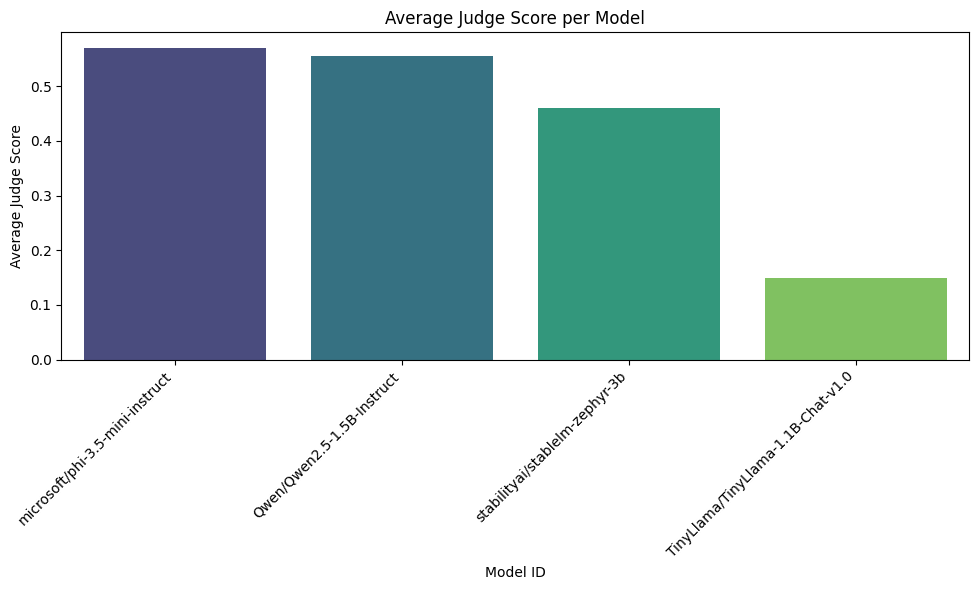

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar chart for Average Judge Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Model_ID', y='Judge Score', data=df_model_avg_scores, palette='viridis')
plt.title('Average Judge Score per Model')
plt.xlabel('Model ID')
plt.ylabel('Average Judge Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
The previous code generated a `FutureWarning` for the `barplot` regarding the `palette` usage. I will modify the barplot to assign the `x` variable to `hue` and set `legend=False` to address this warning. Additionally, to create the grouped bar chart for 'SBERT', 'F1', and 'Recall', I need to melt the `df_model_avg_scores` DataFrame to reshape it for easier plotting of multiple metrics and then use `sns.barplot` with the `hue` parameter.



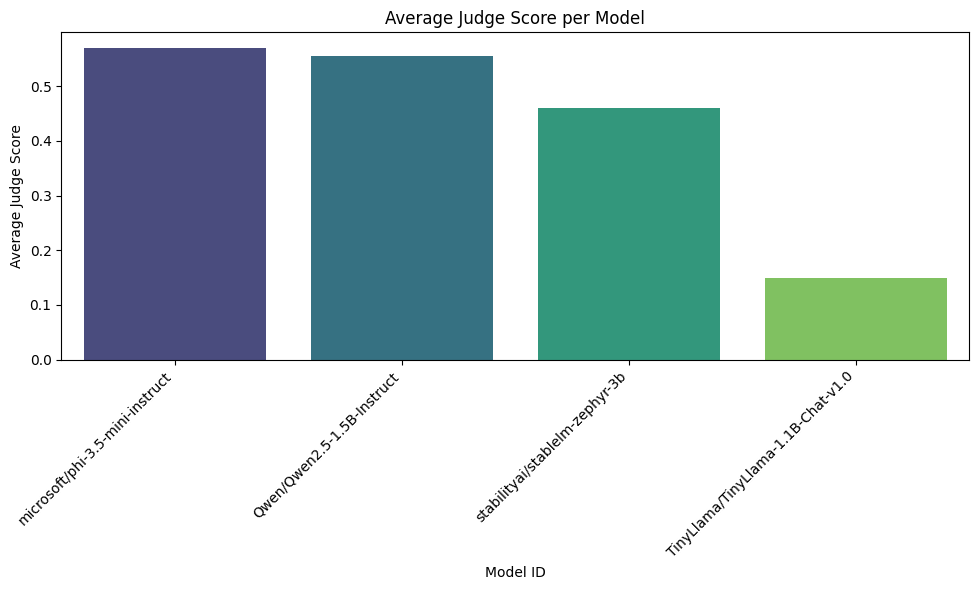

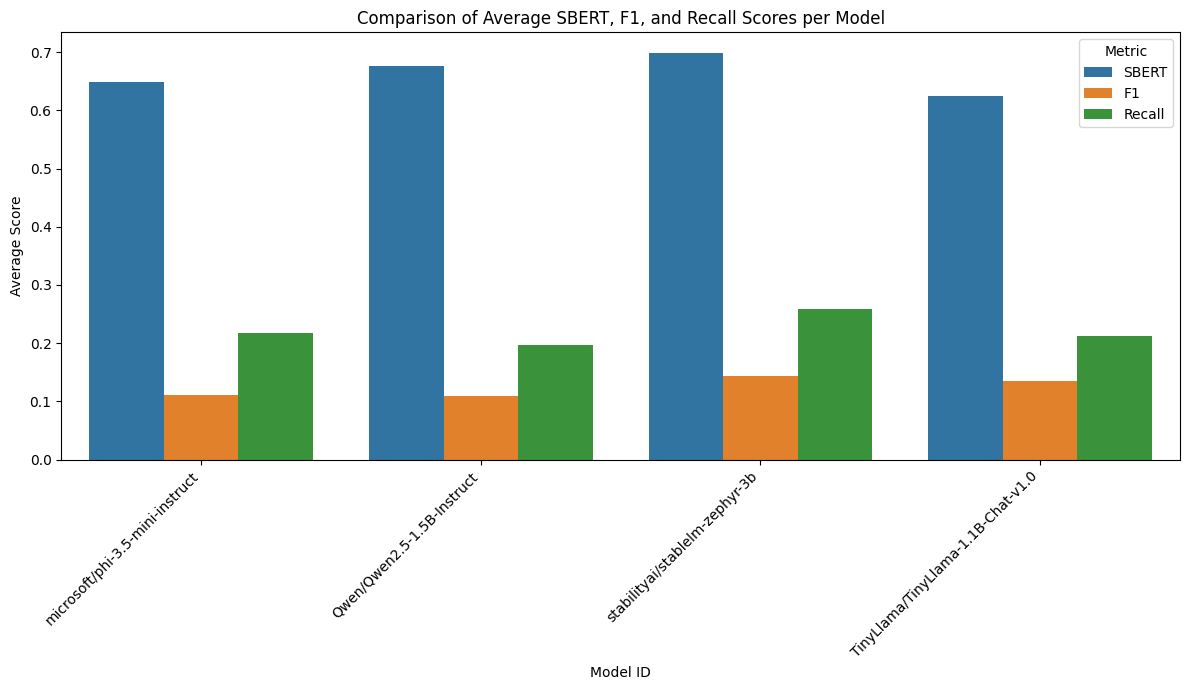

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Bar chart for Average Judge Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Model_ID', y='Judge Score', data=df_model_avg_scores, palette='viridis', hue='Model_ID', legend=False)
plt.title('Average Judge Score per Model')
plt.xlabel('Model ID')
plt.ylabel('Average Judge Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Grouped bar chart for SBERT, F1, and Recall
df_melted_scores = df_model_avg_scores.melt(id_vars=['Model_ID'], value_vars=['SBERT', 'F1', 'Recall'],
                                            var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model_ID', y='Score', hue='Metric', data=df_melted_scores, palette='tab10')
plt.title('Comparison of Average SBERT, F1, and Recall Scores per Model')
plt.xlabel('Model ID')
plt.ylabel('Average Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## Summary of Model Performance and Ranking

Based on the analysis and visualizations, here's a summary of the model performance:

**Average Scores and Ranking (by Judge Score):**

| Model_ID                       | Judge Score | SBERT   | F1      | Recall  |
|:-------------------------------|:------------|:--------|:--------|:--------|
| microsoft/phi-3.5-mini-instruct| 0.570       | 0.64922 | 0.11046 | 0.21798 |
| Qwen/Qwen2.5-1.5B-Instruct     | 0.556       | 0.67688 | 0.10894 | 0.19732 |
| stabilityai/stablelm-zephyr-3b | 0.460       | 0.69906 | 0.14378 | 0.25870 |
| TinyLlama/TinyLlama-1.1B-Chat-v1.0| 0.150       | 0.62386 | 0.13526 | 0.21272 |


**Key Insights:**

1.  **Ranking by Judge Score:**
    *   `microsoft/phi-3.5-mini-instruct` performed the best overall according to the Gemini-based 'Judge Score', with an average score of 0.570. This indicates that the judge model found its responses to be the most relevant and accurate among the evaluated models.
    *   `Qwen/Qwen2.5-1.5B-Instruct` is a close second with an average 'Judge Score' of 0.556.
    *   `stabilityai/stablelm-zephyr-3b` follows with 0.460.
    *   `TinyLlama/TinyLlama-1.1B-Chat-v1.0` scored significantly lower, indicating a poor performance in generating relevant and accurate medical answers as perceived by the judge.

2.  **SBERT Similarity:**
    *   `stabilityai/stablelm-zephyr-3b` achieved the highest average 'SBERT' similarity (0.699), suggesting its responses were semantically closest to the reference answers, even if the 'Judge Score' was lower. This implies it captures the general meaning well but might lack specific factual accuracy or conciseness required by the judge.
    *   `Qwen/Qwen2.5-1.5B-Instruct` also showed a strong SBERT score (0.677).
    *   `TinyLlama/TinyLlama-1.1B-Chat-v1.0` had the lowest SBERT score (0.624), consistent with its low 'Judge Score'.

3.  **F1 and Recall Scores:**
    *   `stabilityai/stablelm-zephyr-3b` achieved the highest F1 score (0.144) and Recall (0.259), suggesting it had better overlap in terms of n-grams with the reference answers. This contrasts with its 'Judge Score', highlighting that simple n-gram overlap doesn't always correlate with perceived answer quality in complex domains like medicine.
    *   The F1 and Recall scores are generally low across all models, which is common in generative AI evaluations where exact word matches are rare, and slight variations can lead to lower n-gram overlap scores.

**Best Performing Model:**

Based purely on the 'Judge Score', which reflects the expert medical evaluator's perception of relevance and accuracy, **`microsoft/phi-3.5-mini-instruct`** is the best-performing model in this evaluation. While other models might show strengths in semantic similarity (SBERT) or n-gram overlap (F1/Recall), the 'Judge Score' provides a more holistic and human-like assessment of the quality of medical responses.

## Final Task

### Subtask:
Summarize the ranking of the models based on their performance metrics and highlight the best-performing model with key insights from the visualizations.


## Summary:

### Q&A
The ranking of the models based on their performance metrics is as follows:
1.  `microsoft/phi-3.5-mini-instruct`
2.  `Qwen/Qwen2.5-1.5B-Instruct`
3.  `stabilityai/stablelm-zephyr-3b`
4.  `TinyLlama/TinyLlama-1.1B-Chat-v1.0`

The best-performing model, based on the 'Judge Score', is `microsoft/phi-3.5-mini-instruct`.

### Data Analysis Key Findings
*   `microsoft/phi-3.5-mini-instruct` was the best-performing model with an average 'Judge Score' of 0.570, indicating it generated the most relevant and accurate responses as perceived by the Gemini-based judge.
*   `Qwen/Qwen2.5-1.5B-Instruct` followed closely with an average 'Judge Score' of 0.556.
*   `stabilityai/stablelm-zephyr-3b` achieved the highest average 'SBERT' similarity (0.699), suggesting its responses were semantically closest to the reference answers despite having a lower 'Judge Score' (0.460).
*   `stabilityai/stablelm-zephyr-3b` also showed the highest F1 score (0.144) and Recall (0.259), indicating better n-gram overlap with reference answers, which did not directly correlate with its 'Judge Score'.
*   `TinyLlama/TinyLlama-1.1B-Chat-v1.0` consistently performed the lowest across all metrics, with an average 'Judge Score' of 0.150 and the lowest SBERT score (0.624).
*   F1 and Recall scores were generally low across all models, which is typical for generative AI evaluations where exact word matches are infrequent.

### Insights or Next Steps
*   The discrepancy between the 'Judge Score' and other metrics (SBERT, F1, Recall) suggests that human-like assessment (via 'Judge Score') captures nuances of response quality in a medical context that semantic and lexical similarity metrics alone do not. This highlights the value of expert judgment in evaluating generative AI for critical domains.
*   Future evaluations should explore methods to improve the correlation between automated metrics and human judgment, possibly by incorporating more domain-specific semantic understanding into automated metrics or by fine-tuning models specifically to optimize for 'Judge Score' criteria.
